In [10]:

# Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
import random
from tqdm import tqdm
import numpy as np

sns.set_style("darkgrid")

## Eye Fundus Image Dataset EDA

This notebook performs Exploratory Data Analysis (EDA) on the **Unified Split dataset** for diabetic retinopathy classification.  

We analyze:  
- Dataset statistics per split  
- Class distributions  
- Sample images  
- Image sizes and aspect ratios  
- Pixel intensity distributions  
- Color channel statistics (mean & std)


In [2]:
# Paths
UNIFIED_DIR = "datasets/Unified_Split"  # Original unified dataset before preprocessing
splits = ["train", "val", "test"]
classes = ["DR", "No_DR"]

###  Dataset Statistics

We first check the number of images per class for each split (train, validation, and test) to understand the dataset balance.


In [9]:
#  Dataset Statistics
print("Dataset Image Counts per Split")
for split in splits:
    print(f"\n-- {split.upper()} --")
    for cls in classes:
        folder = os.path.join(UNIFIED_DIR, split, cls)
        count = len([f for f in os.listdir(folder) if f.lower().endswith((".jpg", ".png", ".jpeg", ".tif"))])
        print(f"{cls}: {count} images")

# Plot class distribution in training set
for split in splits:
    counts = [len([f for f in os.listdir(os.path.join(UNIFIED_DIR, split, cls)) 
                   if f.lower().endswith((".jpg", ".png", ".jpeg", ".tif"))]) for cls in classes]
    
    plt.figure(figsize=(6,4))
    sns.barplot(x=classes, y=counts, palette="Set2")
    plt.title(f"{split.capitalize()} Set Class Distribution")
    plt.ylabel("Number of Images")
    plt.show()

Dataset Image Counts per Split


NameError: name 'splits' is not defined

### Class Distribution Visualization

We plot **bar graphs** showing the number of images per class in **train, validation, and test sets** to visualize dataset balance.


Random samples from train set:


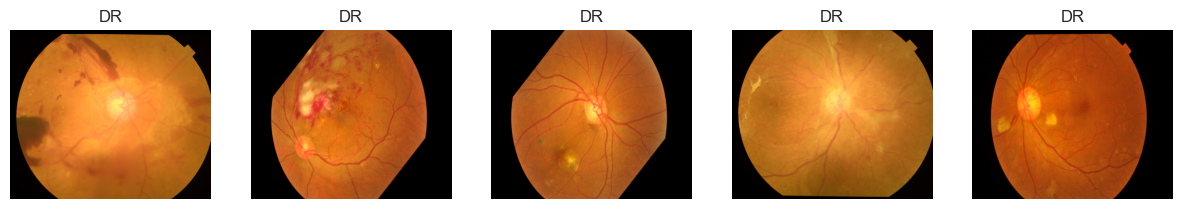

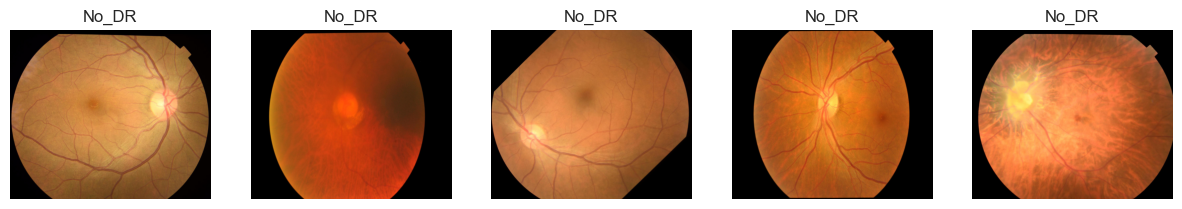

Random samples from val set:


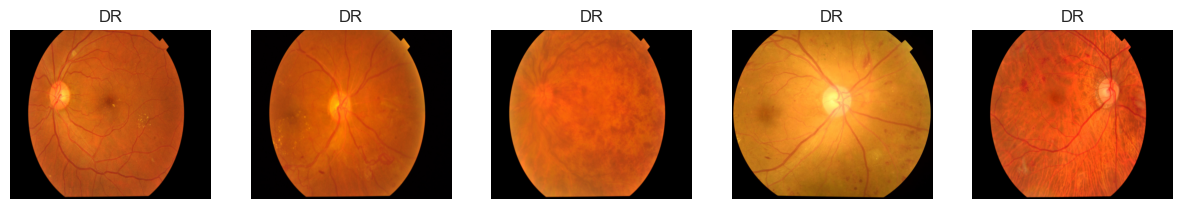

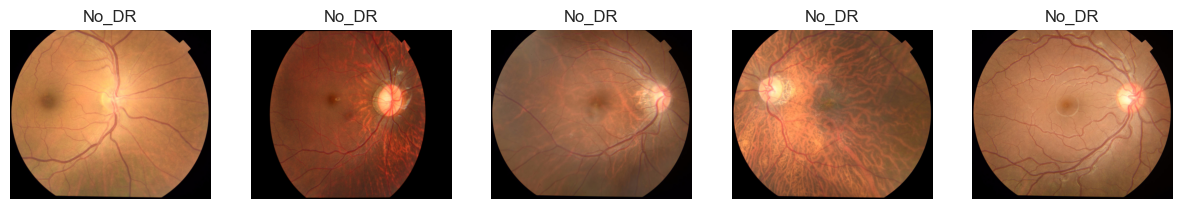

Random samples from test set:


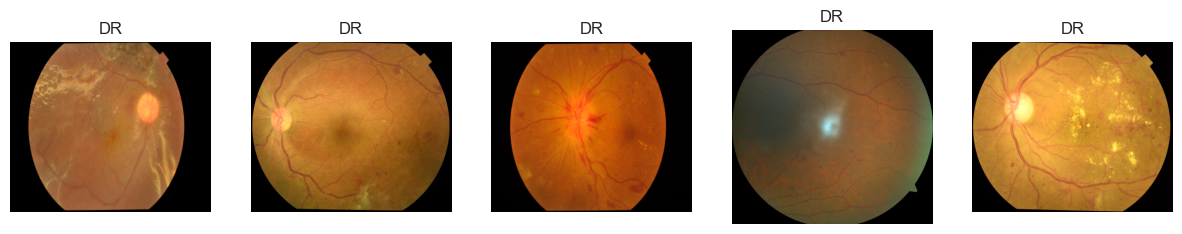

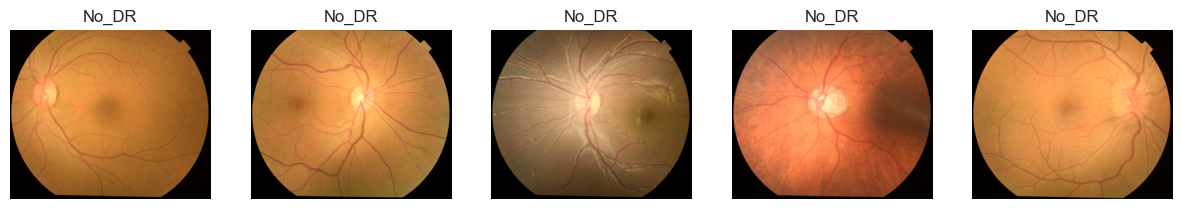

In [4]:
#  Display Random Sample Images
def show_random_images(split="train", num_samples=5):
    print(f"Random samples from {split} set:")
    for cls in classes:
        folder = os.path.join(UNIFIED_DIR, split, cls)
        images = [f for f in os.listdir(folder) if f.lower().endswith((".jpg", ".png", ".jpeg", ".tif"))]
        samples = random.sample(images, min(num_samples, len(images)))

        plt.figure(figsize=(15,3))
        for i, img_name in enumerate(samples):
            img_path = os.path.join(folder, img_name)
            img = Image.open(img_path)
            plt.subplot(1, len(samples), i+1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"{cls}")
        plt.show()

show_random_images("train", 5)
show_random_images("val", 5)
show_random_images("test", 5)

###  Random Sample Images

Display a few **random images** from each class in the train, validation, and test splits.  
This allows for visual inspection of image quality and diversity.


Calculating image sizes...


test/No_DR: 100%|██████████████████████████████████████████████████████████████████| 330/330 [00:00<00:00, 7077.15it/s]


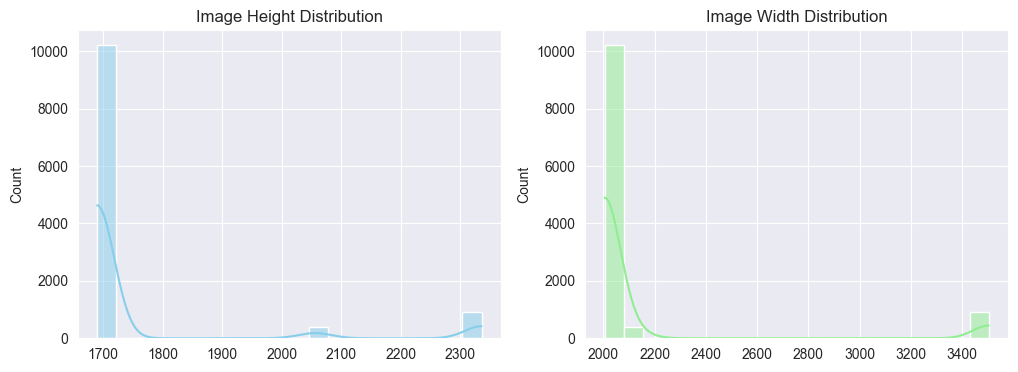

In [7]:
print("Calculating image sizes...")

all_heights, all_widths = [], []

for split in splits:
    for cls in classes:
        folder = os.path.join(UNIFIED_DIR, split, cls)
        for img_name in tqdm(os.listdir(folder), desc=f"{split}/{cls}"):
            if not img_name.lower().endswith((".jpg", ".png", ".jpeg", ".tif")):
                continue
            img_path = os.path.join(folder, img_name)
            try:
                with Image.open(img_path) as img:
                    w, h = img.size
                    all_widths.append(w)
                    all_heights.append(h)
            except:
                continue  # skip corrupted images

# Plot distributions
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.histplot(all_heights, bins=20, kde=True, color='skyblue')
plt.title("Image Height Distribution")

plt.subplot(1,2,2)
sns.histplot(all_widths, bins=20, kde=True, color='lightgreen')
plt.title("Image Width Distribution")

plt.show()

### Aspect Ratio Analysis

Plot the distribution of **image aspect ratios (width / height)** to observe shape variations in the dataset.


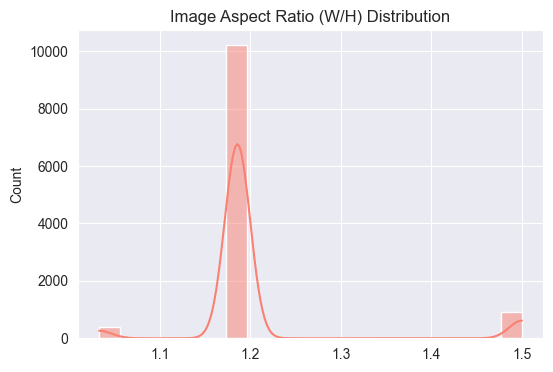

In [8]:
#  Aspect Ratio Distribution
aspect_ratios = [w/h for w,h in zip(all_widths, all_heights)]
plt.figure(figsize=(6,4))
sns.histplot(aspect_ratios, bins=20, kde=True, color='salmon')
plt.title("Image Aspect Ratio (W/H) Distribution")
plt.show()


### Approximate Per-Channel Mean & Standard Deviation

- To get a quick estimate of the mean and standard deviation of the RGB channels for our dataset, we sample a subset of images from each split (`train`, `val`, `test`) instead of processing the entire dataset. This helps speed up computations significantly.

- We then call this function for **train**, **val**, and **test** splits.


In [6]:
# Define dataset path and classes
UNIFIED_DIR = "datasets/Unified_Split"  # Change this if your path is different
classes = ["DR", "No_DR"]

# Quick mean & std approximation function
def quick_mean_std(split="train", classes=classes, sample_size=20):
    channel_sums = np.zeros(3)
    channel_squared_sums = np.zeros(3)
    num_pixels = 0

    for cls in classes:
        folder = os.path.join(UNIFIED_DIR, split, cls)
        imgs = [os.path.join(folder, f) for f in os.listdir(folder)
                if f.lower().endswith((".jpg", ".png", ".jpeg", ".tif"))]

        # Randomly sample a few images to approximate
        imgs_sample = random.sample(imgs, min(sample_size, len(imgs)))

        for img_path in imgs_sample:
            try:
                with Image.open(img_path) as img:
                    img = img.convert("RGB")
                    arr = np.array(img) / 255.0
                    arr = arr.reshape(-1,3)
                    channel_sums += arr.sum(axis=0)
                    channel_squared_sums += (arr ** 2).sum(axis=0)
                    num_pixels += arr.shape[0]
            except:
                continue

    mean = channel_sums / num_pixels
    std = np.sqrt(channel_squared_sums / num_pixels - mean**2)

    print(f"Approx Mean (R,G,B): {mean}")
    print(f"Approx Std  (R,G,B): {std}")

# Call the function
print("Train:")
quick_mean_std("train")
print("Val:")
quick_mean_std("val")
print("Test:")
quick_mean_std("test")

Train:
Approx Mean (R,G,B): [0.55140074 0.30079788 0.15558836]
Approx Std  (R,G,B): [0.32239346 0.2079168  0.16228022]
Val:
Approx Mean (R,G,B): [0.56443643 0.32998633 0.1476289 ]
Approx Std  (R,G,B): [0.33045469 0.19980979 0.11444753]
Test:
Approx Mean (R,G,B): [0.52745447 0.3178159  0.15747113]
Approx Std  (R,G,B): [0.31472478 0.20721857 0.13895453]
